In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
        
#Scaling and Splitting
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from sklearn.model_selection import train_test_split

#Modeling
from sklearn.linear_model import LassoLars
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

#Evaluation
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error

/kaggle/input/trailer-prices/trailerdata1.csv
/kaggle/input/trailer-prices/trailerdata2.csv


# About this notebook
This notebook aims to predict the price of a product (trailer) for an early stage start-up. The data has been anonymized. Due to the web infrastructure of manufacturers of similar trailers, the data was collected by hand. This project is still on-going and updated regularly. 

## Current Challenges
Currently the challenge is to deal with the small amount of data. There are unfortunately not many data points available in general, but work is underway to fill in vital details to increase the dataset as much as possible. 

In [2]:
#The trailer price data is saved in a csv file and must first be loaded
data = pd.read_csv('/kaggle/input/trailer-prices/trailerdata1.csv', sep=';')
data.tail(15)

,total dry weight,length,exterior width,exterior height,interior height,Roof Rack,Driver Side Window,Driver Side Door,Driver Side Door Window,Passenger Side Door,Passenger Side Door Window,Passenger Side Window,Rear Door,Rear Door Window,Spare Tire,Cabinets,Refrigerator,Awning,price
69,1350.0,165,80.0,68.75,44.5,Yes,No,Yes,Yes,Yes,Yes,No,No,No,Option,Yes,Option,Yes,16250
70,1350.0,165,60.0,68.75,44.5,Yes,No,Yes,Yes,Yes,Yes,No,No,No,Option,Yes,Option,Yes,17250
71,1750.0,200,80.0,69.00,44.5,Yes,No,Yes,Yes,Yes,Yes,No,No,No,Option,Yes,Option,Yes,19950
72,2200.0,110,60.0,48.00,45.0,Yes,No,Yes,Yes,Yes,Yes,No,No,No,Yes,Yes,No,Yes,38990
73,3750.0,156,86.0,63.75,78.0,No,Yes,No,No,No,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,79990
74,640.0,140,76.0,62.00,38.0,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No,No,Yes,No,No,9950
75,1200.0,157,72.0,64.00,42.0,Option,No,Yes,Yes,Yes,Yes,No,No,No,No,Yes,No,No,30590
76,1025.0,149,83.0,72.00,45.0,Option,Yes,No,No,Yes,Yes,Yes,Yes,No,Yes,Yes,No,Option,13174
77,1115.0,165,83.0,72.00,45.0,Option,Yes,No,No,Yes,Yes,Yes,Yes,No,Yes,Yes,No,Option,14350
78,1450.0,165,92.0,95.00,66.0,Option,No,Yes,No,Yes,Yes,Yes,Yes,No,Yes,Yes,No,Option,20230


In [3]:
#inspect the data types of each column
#for modeling everything needs to be and int or float
data.dtypes

total dry weight              float64
length                          int64
exterior width                float64
exterior height               float64
interior height               float64
Roof Rack                      object
Driver Side Window             object
Driver Side Door               object
Driver Side Door Window        object
Passenger Side Door            object
Passenger Side Door Window     object
Passenger Side Window          object
Rear Door                      object
Rear Door Window               object
Spare Tire                     object
Cabinets                       object
Refrigerator                   object
Awning                         object
price                           int64
dtype: object

In [4]:
#checking for missing values
#missing values must be dealt with for ML modeling
data.isna().sum()

total dry weight              0
length                        0
exterior width                0
exterior height               0
interior height               0
Roof Rack                     0
Driver Side Window            0
Driver Side Door              0
Driver Side Door Window       0
Passenger Side Door           0
Passenger Side Door Window    0
Passenger Side Window         0
Rear Door                     0
Rear Door Window              0
Spare Tire                    0
Cabinets                      0
Refrigerator                  0
Awning                        0
price                         0
dtype: int64

In [5]:
#drop columns which contain many empty values that are unlikely to be helpful in calculations
#data.drop(['model', 'year', 'sleeps', 'aluminum siding (inch)', 'A/C', 'msrp'], axis=1)

In [6]:
#83 is the target but it will be removed later to prevent problems later
#data2=data.drop(data.index[[83]])

In [7]:
data

,total dry weight,length,exterior width,exterior height,interior height,Roof Rack,Driver Side Window,Driver Side Door,Driver Side Door Window,Passenger Side Door,Passenger Side Door Window,Passenger Side Window,Rear Door,Rear Door Window,Spare Tire,Cabinets,Refrigerator,Awning,price
0,1660.0,198,102.0,84.0,54.0,Option,Yes,No,No,Yes,Yes,Yes,No,No,Yes,Yes,Yes,Option,14879
1,2260.0,194,102.0,108.0,74.0,Option,Yes,No,No,Yes,Yes,Yes,No,No,Yes,Yes,Yes,No,18489
2,1320.0,144,102.0,90.0,54.0,Option,Yes,No,No,Yes,Yes,Yes,No,No,Yes,Yes,Yes,Option,12500
3,1320.0,144,102.0,90.0,54.0,Option,Yes,No,No,Yes,Yes,Yes,No,No,Yes,Yes,Yes,Option,14997
4,1930.0,185,102.0,105.0,73.0,Option,Yes,No,No,Yes,Yes,Yes,No,No,Yes,Yes,Yes,Option,15965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,2475.0,216,102.0,102.0,83.0,Option,Yes,Yes,No,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Option,28056
80,1500.0,168,80.0,66.0,43.5,Option,No,Yes,Yes,Yes,Yes,No,No,No,Yes,Yes,Option,Option,18849
81,1500.0,168,80.0,72.0,43.5,Option,No,Yes,Yes,Yes,Yes,No,No,No,Yes,Yes,Option,Option,19899
82,1250.0,168,80.0,68.0,43.5,Option,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,Option,Yes,Option,Option,15099


In [8]:
data.isna().sum()

total dry weight              0
length                        0
exterior width                0
exterior height               0
interior height               0
Roof Rack                     0
Driver Side Window            0
Driver Side Door              0
Driver Side Door Window       0
Passenger Side Door           0
Passenger Side Door Window    0
Passenger Side Window         0
Rear Door                     0
Rear Door Window              0
Spare Tire                    0
Cabinets                      0
Refrigerator                  0
Awning                        0
price                         0
dtype: int64

In [9]:
data.shape

(84, 19)

In [10]:
#these columns will be renamed to remove the space in the heading 
data = data.rename(columns={"exterior height": "eheight", "total dry weight": "tdweight", "interior height":"intheight", "exterior width":"ewidth"})

In [11]:
#data2['intheight'] = data2['intheight'].fillna(data2['intheight'].mean())
#data2['ewidth'] = data2['ewidth'].fillna(data2['ewidth'].mean())

In [12]:
data.isna().sum()

tdweight                      0
length                        0
ewidth                        0
eheight                       0
intheight                     0
Roof Rack                     0
Driver Side Window            0
Driver Side Door              0
Driver Side Door Window       0
Passenger Side Door           0
Passenger Side Door Window    0
Passenger Side Window         0
Rear Door                     0
Rear Door Window              0
Spare Tire                    0
Cabinets                      0
Refrigerator                  0
Awning                        0
price                         0
dtype: int64

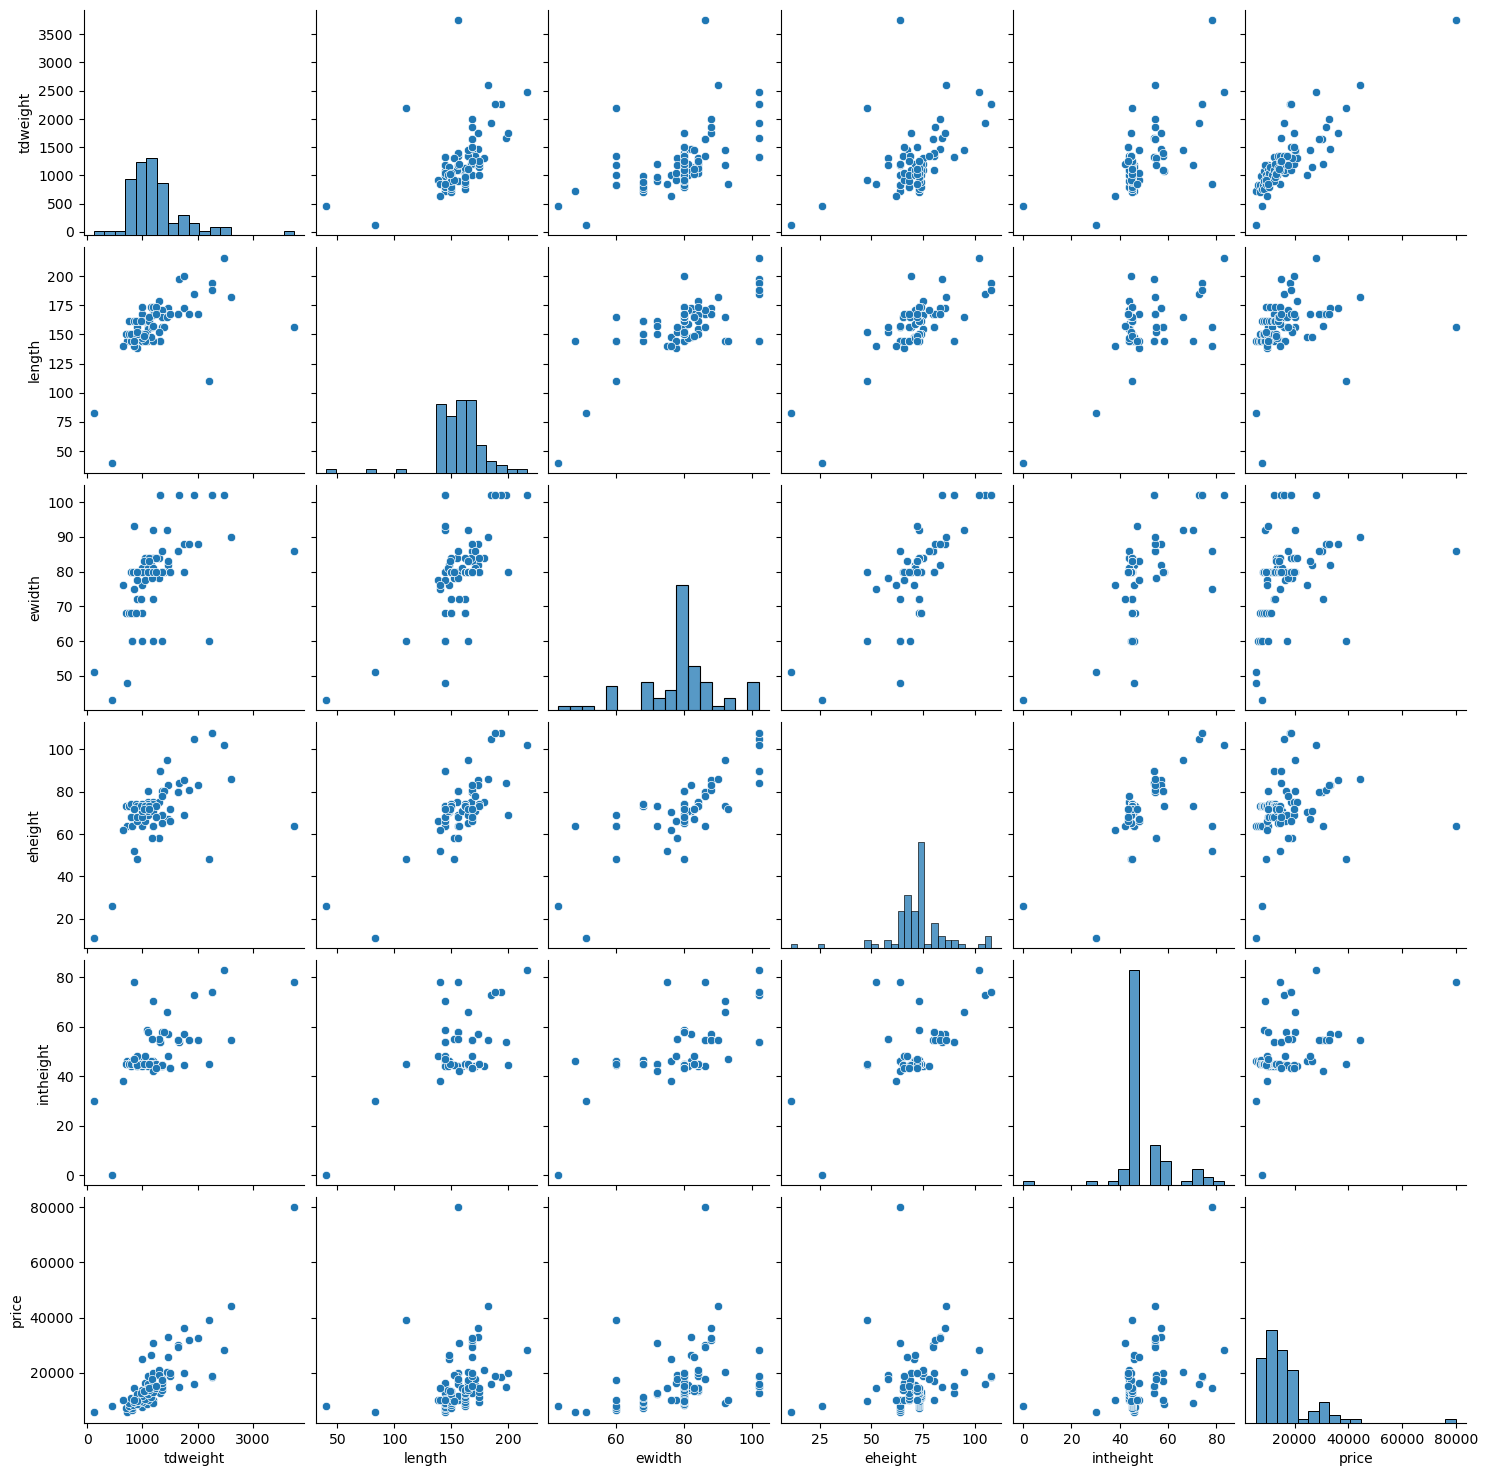

In [13]:
sns.pairplot(data)

Of all the variables, total dry weight appears to be the most correlated with the price. Let's look at it a bit more closely. 

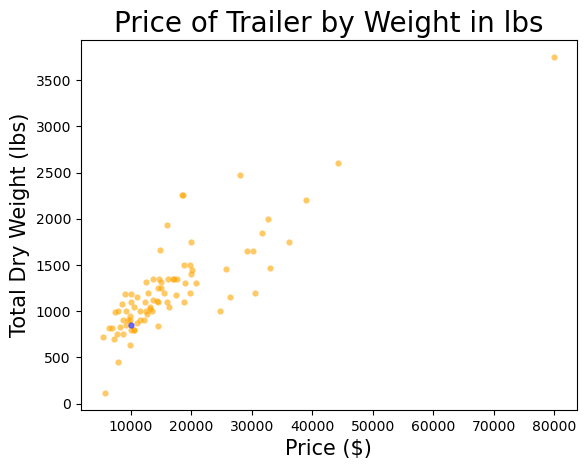

In [14]:
# values of x
x=data['price']
y= data['tdweight']

col = []
  
for i in range(0, len(x)):
    if x[i]==9995:
        col.append('blue')  
    else:
        col.append('orange') 
  
for i in range(len(x)):
      
    # plotting the corresponding x with y 
    # and respective color
    plt.scatter(x[i], y[i], c = col[i], s = 20,
                linewidth = 0, alpha=0.6)
    plt.title("Price of Trailer by Weight in lbs", fontsize=20)
    plt.ylabel("Total Dry Weight (lbs)", fontsize=15)
    plt.xlabel("Price ($)", fontsize=15)
      
plt.show()

In [15]:
#select the categorical data for encoding
cat_data = data.iloc[:, 5:18]
cat_data

,Roof Rack,Driver Side Window,Driver Side Door,Driver Side Door Window,Passenger Side Door,Passenger Side Door Window,Passenger Side Window,Rear Door,Rear Door Window,Spare Tire,Cabinets,Refrigerator,Awning
0,Option,Yes,No,No,Yes,Yes,Yes,No,No,Yes,Yes,Yes,Option
1,Option,Yes,No,No,Yes,Yes,Yes,No,No,Yes,Yes,Yes,No
2,Option,Yes,No,No,Yes,Yes,Yes,No,No,Yes,Yes,Yes,Option
3,Option,Yes,No,No,Yes,Yes,Yes,No,No,Yes,Yes,Yes,Option
4,Option,Yes,No,No,Yes,Yes,Yes,No,No,Yes,Yes,Yes,Option
...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,Option,Yes,Yes,No,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Option
80,Option,No,Yes,Yes,Yes,Yes,No,No,No,Yes,Yes,Option,Option
81,Option,No,Yes,Yes,Yes,Yes,No,No,No,Yes,Yes,Option,Option
82,Option,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,Option,Yes,Option,Option


In [16]:
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()

#label encode the data to prepare for modeling
#label encoding is preferred for categorical variables

for col in cat_data:
    data[col] = labelencoder.fit_transform(data[col])
 
data.head()

,tdweight,length,ewidth,eheight,intheight,Roof Rack,Driver Side Window,Driver Side Door,Driver Side Door Window,Passenger Side Door,Passenger Side Door Window,Passenger Side Window,Rear Door,Rear Door Window,Spare Tire,Cabinets,Refrigerator,Awning,price
0,1660.0,198,102.0,84.0,54.0,1,2,0,0,1,2,1,2,0,2,1,2,1,14879
1,2260.0,194,102.0,108.0,74.0,2,2,0,0,1,2,1,2,0,2,1,2,0,18489
2,1320.0,144,102.0,90.0,54.0,2,2,0,0,1,2,1,2,0,2,1,2,1,12500
3,1320.0,144,102.0,90.0,54.0,2,2,0,0,1,2,1,2,0,2,1,2,1,14997
4,1930.0,185,102.0,105.0,73.0,2,2,0,0,1,2,1,2,0,2,1,2,1,15965


In [17]:
#make a copy of the data for later
data2=data

In [18]:
corr=data2.corr()
corr

,tdweight,length,ewidth,eheight,intheight,Roof Rack,Driver Side Window,Driver Side Door,Driver Side Door Window,Passenger Side Door,Passenger Side Door Window,Passenger Side Window,Rear Door,Rear Door Window,Spare Tire,Cabinets,Refrigerator,Awning,price
tdweight,1.000000,0.518976,0.543652,0.492137,0.638106,-0.128789,0.182358,-0.139447,-0.072662,0.030176,0.187728,0.172285,-0.050971,0.324525,0.456442,0.432806,0.531412,0.156676,0.841382
length,0.518976,1.000000,0.643688,0.742599,0.555096,0.143129,0.174515,0.168083,0.179606,0.512541,0.426566,0.216883,0.040188,-0.052231,0.309560,0.381618,0.433223,0.240774,0.250673
ewidth,0.543652,0.643688,1.000000,0.746189,0.621214,0.096535,0.174815,-0.205003,-0.013142,0.405831,0.397780,0.303792,0.092160,0.137467,0.558831,0.500621,0.570599,0.134765,0.305946
eheight,0.492137,0.742599,0.746189,1.000000,0.636278,0.106395,0.325458,-0.072198,-0.082252,0.527838,0.400729,0.388813,0.058657,-0.047788,0.376130,0.298362,0.429741,-0.017290,0.180189
intheight,0.638106,0.555096,0.621214,0.636278,1.000000,-0.002463,0.273729,-0.225500,-0.272869,0.060171,0.132096,0.274008,0.046726,0.192370,0.278680,0.141254,0.312246,-0.143488,0.411130
Roof Rack,-0.128789,0.143129,0.096535,0.106395,-0.002463,1.000000,-0.313792,0.156018,0.072595,0.255696,-0.173519,-0.141230,0.352566,-0.043219,-0.010375,-0.041642,0.003351,0.436492,-0.281615
Driver Side Window,0.182358,0.174515,0.174815,0.325458,0.273729,-0.313792,1.000000,-0.161904,-0.180882,0.117672,0.192591,0.816373,-0.276983,-0.040582,0.040185,-0.034687,0.311479,-0.350992,0.016880
Driver Side Door,-0.139447,0.168083,-0.205003,-0.072198,-0.225500,0.156018,-0.161904,1.000000,0.676139,0.355050,0.045367,-0.108207,-0.069628,-0.296442,-0.211378,-0.004255,-0.021228,0.308460,-0.032344
Driver Side Door Window,-0.072662,0.179606,-0.013142,-0.082252,-0.272869,0.072595,-0.180882,0.676139,1.000000,0.353425,0.492170,-0.099730,-0.226242,-0.053367,-0.030663,0.181447,0.126422,0.364775,0.089811
Passenger Side Door,0.030176,0.512541,0.405831,0.527838,0.060171,0.255696,0.117672,0.355050,0.353425,1.000000,0.513706,0.158074,-0.016705,-0.290744,0.189338,0.296869,0.144078,0.175171,-0.144650


<AxesSubplot:>

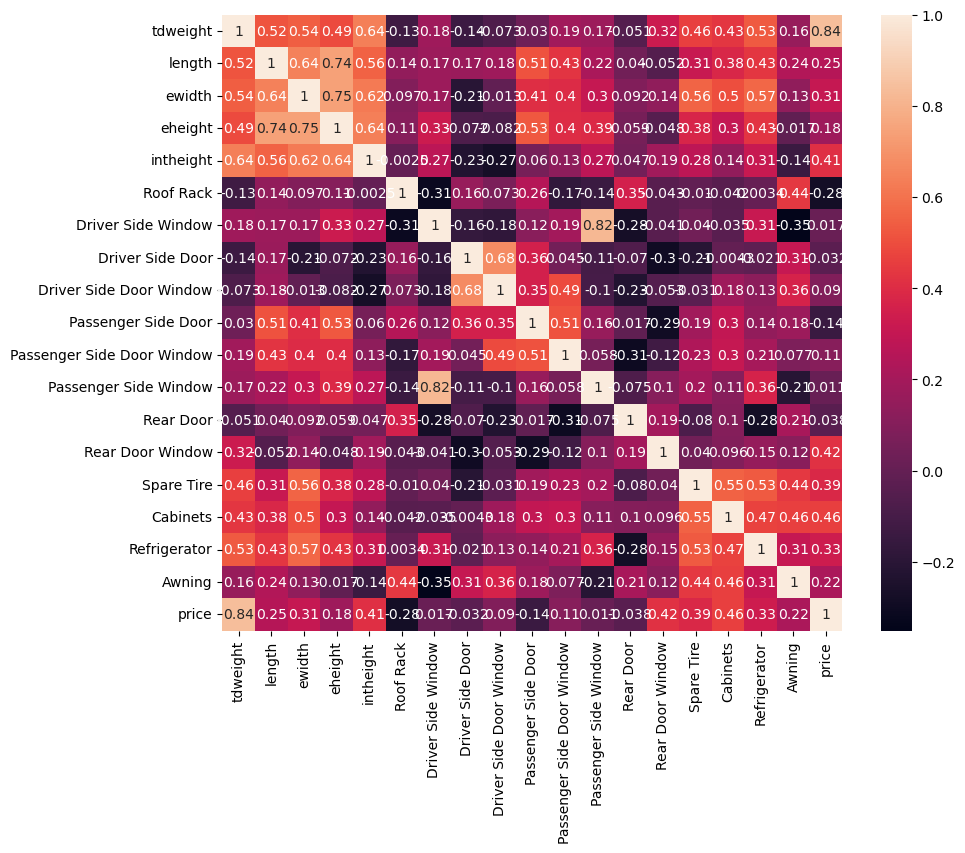

In [19]:
plt.figure(figsize=(10,8))
sns.heatmap(corr,annot=True)

# Machine Learning Modeling
The data is now clean and we can move forward with creating some machine learning models. Once we settle on the best model it can be used to predict the target price of the trailer in question.

#Replace "option" with "no" and try modeling again

In [20]:
data2=data2.drop(data.index[[83]])

In [21]:
#here the data is split up into X,y where X contains everything but price and y contains what we want to predict (price)
#price is what we want to predict
X = data2.drop(['price'],axis=1)
y=data2['price']

In [22]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=1)

In [23]:
#scaling the data
#this usually helps with modeling
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [24]:
#function which runs different ML models and prints R^2, MAE and RMSE
def run_experiment(model):
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    print("R^2 : ", r2_score(y_test, y_pred))
    print("MAE :", mean_absolute_error(y_test,y_pred))
    print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred)))

Now the data is all cleaned up and ready for creating some machine learning models. A funtion has been written to run various models and output metrics 

In [25]:
model_1 = LinearRegression()
run_experiment(model_1)

R^2 :  0.8891242197793296
MAE : 3370.8179322220085
RMSE: 5007.064636453683


In [26]:
model_2 = DecisionTreeRegressor(random_state = 1)
run_experiment(model_2)

R^2 :  0.10688472042267749
MAE : 5002.714285714285
RMSE: 14210.802803970413


In [27]:
model_3 = Ridge(alpha=100, solver='cholesky', tol=0.0001, random_state=1)
run_experiment(model_3)

R^2 :  0.30405116561676804
MAE : 6365.58691259249
RMSE: 12544.504429588942


In [28]:
model_4 = Lasso(alpha=0.1, precompute=True, positive=True, selection='random', random_state=1)
run_experiment(model_4)

R^2 :  0.6604171677365663
MAE : 4847.398032276983
RMSE: 8762.695419253814


In [29]:
model_5 = ElasticNet(alpha=0.1, l1_ratio=0.9, selection='random', random_state=1)
run_experiment(model_5)

R^2 :  0.8726959751066239
MAE : 3460.557879386123
RMSE: 5365.200058424746


In [30]:
model_6 = LassoLars(alpha=.1)
run_experiment(model_6)

R^2 :  0.8887568508642155
MAE : 3372.905435259621
RMSE: 5015.352825034181


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_base.py:138: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,


In [31]:
model_7 = BayesianRidge()
run_experiment(model_7)

R^2 :  0.8048458491150667
MAE : 3761.2297408819168
RMSE: 6642.839353217289


In [32]:
model_8 = SGDRegressor(max_iter=1000, tol=1e-3)
run_experiment(model_8)

R^2 :  0.8361090585354494
MAE : 3688.0397377940085
RMSE: 6087.547014408079


In [33]:
model_9 = SVR(epsilon=0.2)
run_experiment(model_9)

R^2 :  -0.01525593123440494
MAE : 6630.2422007397
RMSE: 15151.395017141267


In [34]:
model_10 = RandomForestRegressor(n_estimators=100, min_samples_leaf=3, random_state=1)
run_experiment(model_10)

R^2 :  0.341565864869412
MAE : 4954.983637243709
RMSE: 12201.719086110135


Unsurprisingly, RandomForest preformed better than all the other models tested. Therefore we will move forward with tuning hyperparameters to figure out which produce the best result.

# Checking Feature Importance

In [35]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X = data2.drop(['price'],axis=1)
y=data2['price']
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the columns
print(featureScores.nlargest(20,'Score'))  #print 10 best features

                         Specs         Score
0                     tdweight  17533.022535
1                       length    256.109233
3                      eheight    218.186520
4                    intheight    205.070507
2                       ewidth    137.680953
13            Rear Door Window     82.000000
6           Driver Side Window     58.628571
8      Driver Side Door Window     56.238532
16                Refrigerator     52.544776
5                    Roof Rack     41.893103
7             Driver Side Door     34.366412
10  Passenger Side Door Window     32.375940
17                      Awning     29.813953
14                  Spare Tire     28.836364
11       Passenger Side Window     25.271930
15                    Cabinets     22.308333
12                   Rear Door     17.609551
9          Passenger Side Door      5.000000


[0.19758916 0.16467314 0.10190226 0.12491065 0.06017583 0.05914519
 0.02548797 0.01897096 0.02037472 0.00977045 0.01851098 0.02191508
 0.03559982 0.00282377 0.03351472 0.03515398 0.03699897 0.03248234]


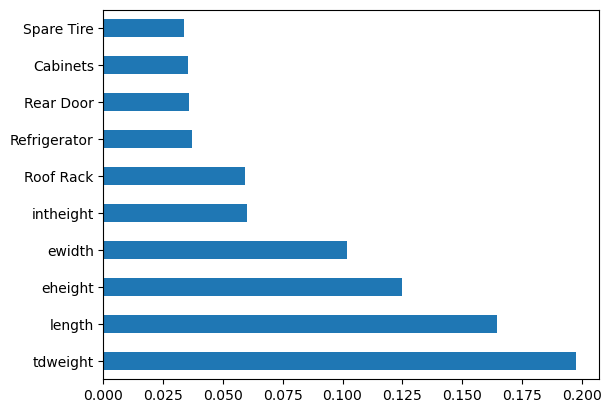

In [36]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

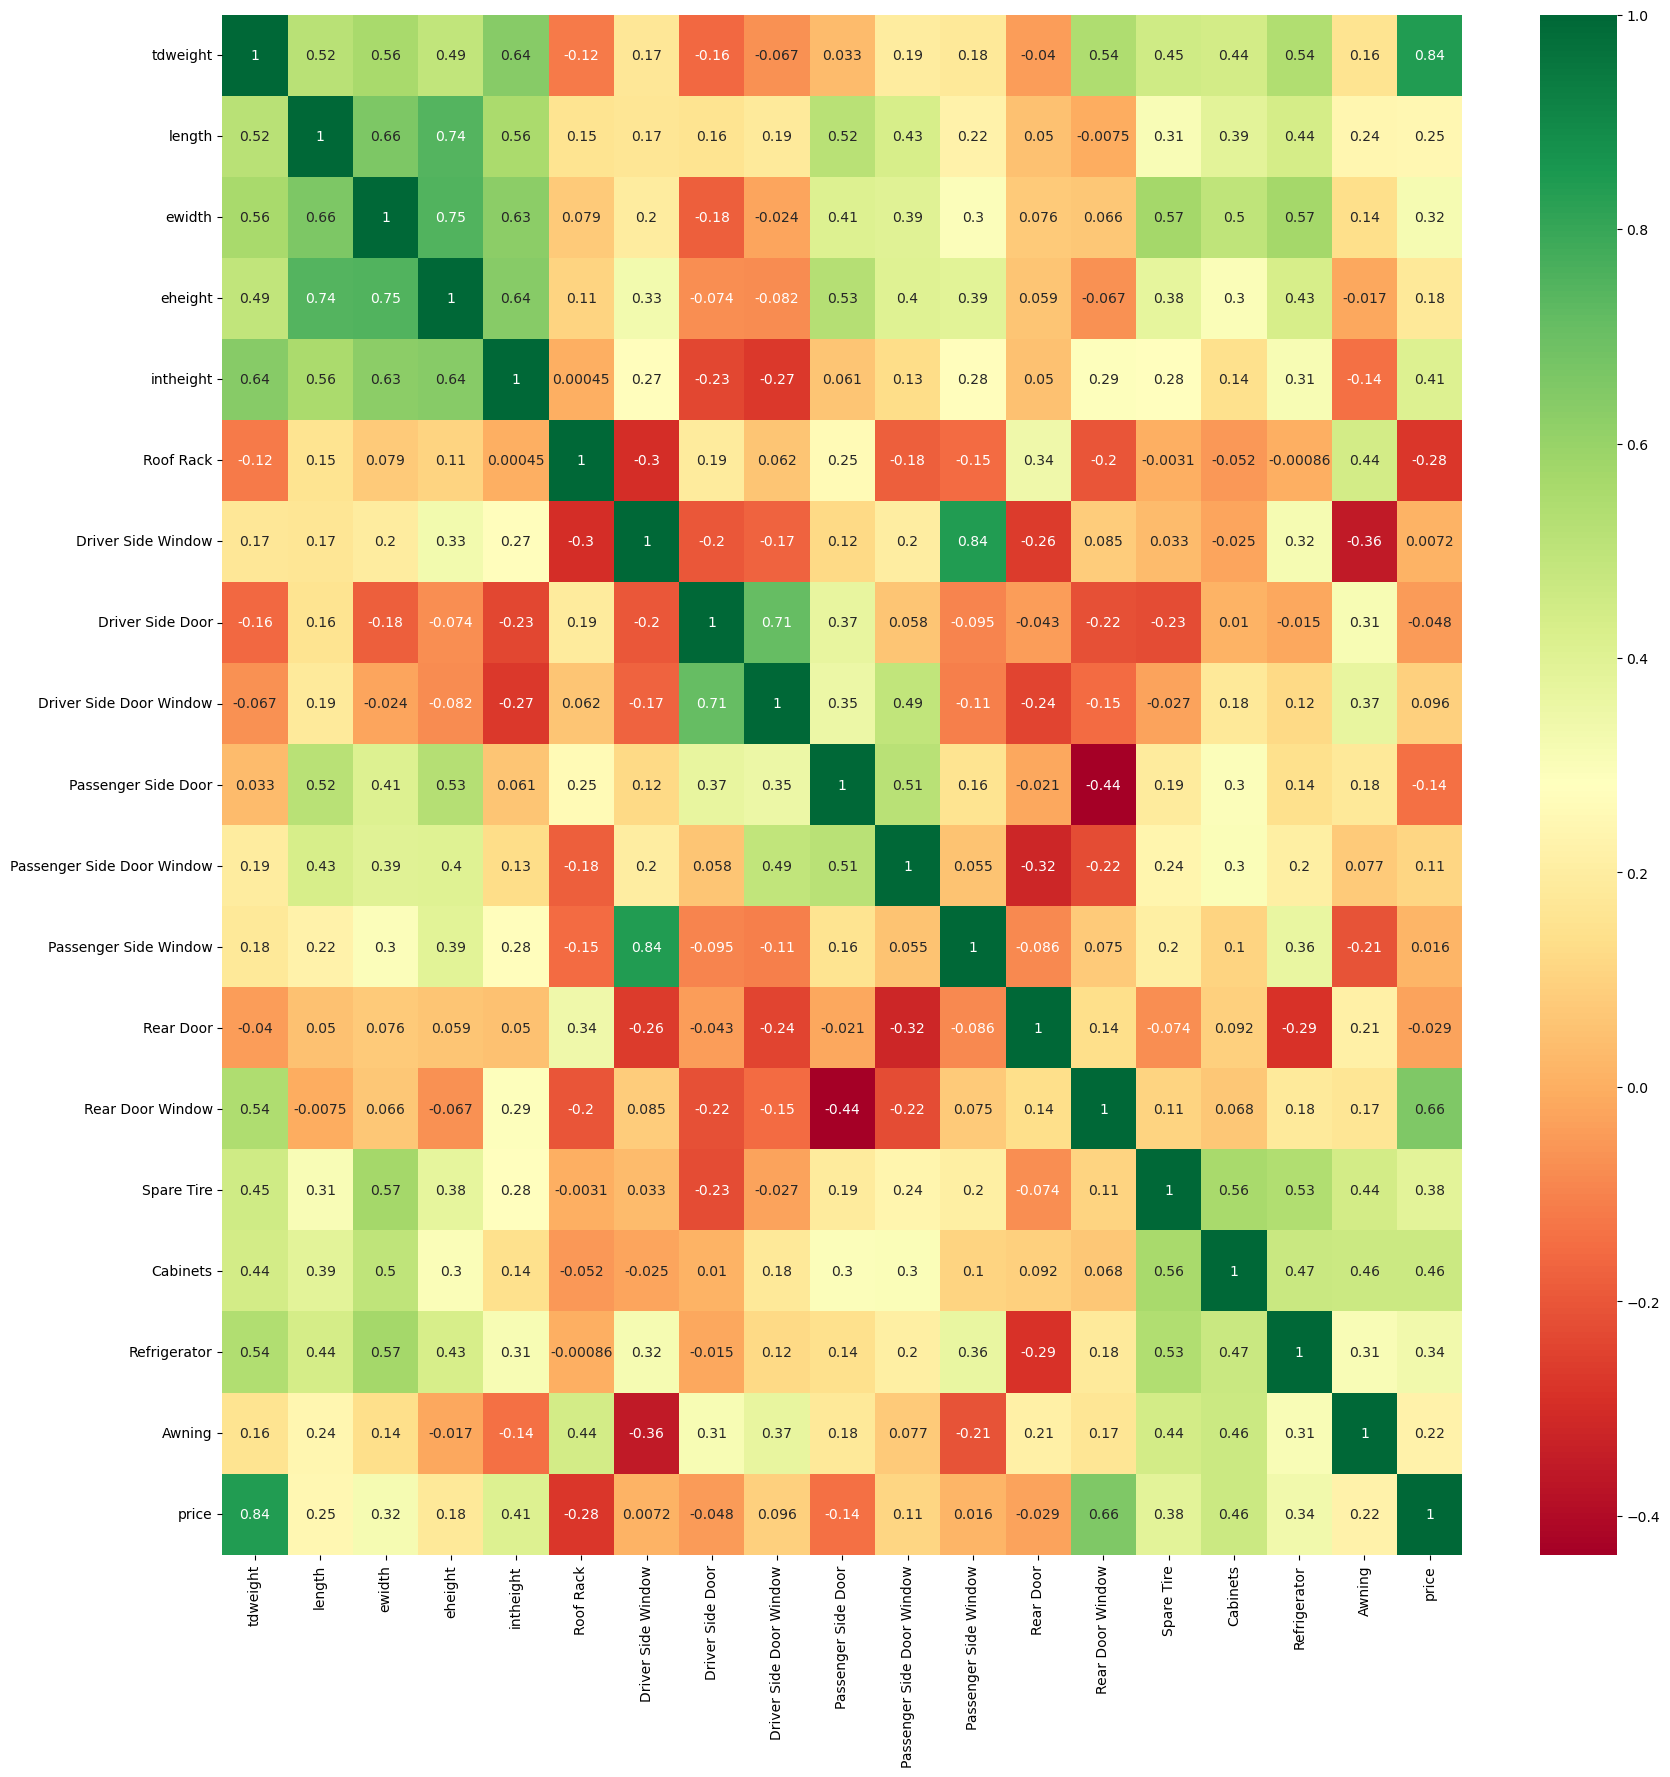

In [37]:
#get correlations of each features in dataset
corrmat = data2.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data2[top_corr_features].corr(),annot=True,cmap="RdYlGn")

## Hyperparameter Tuning
Perhaps it is a bit early to get into hyperparameter tuning, but nonetheless the code is ready for once the dataset has been expanded :) Commented out for time saving purposes.

In [38]:
rfc=RandomForestRegressor(random_state=1)

In [39]:
#param_grid = { 
    #'n_estimators': [100, 500, 1000, 5000],
    #'max_features': ['auto', 'sqrt', 'log2'],
    #to save time in updating the notebook, max_depth is also left out
    #'max_depth' : [5, 10, 15],
    #'min_samples_leaf' : [1,2,3,5],
    #'criterion' :['squared_error', 'absolute_error', 'friedman_mse']
#}


In [40]:
#CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 3)
#CV_rfc.fit(X_train_scaled, y_train)

In [41]:
#print the best parameters determined in GridSearchCV
#CV_rfc.best_params_

In [42]:
#run a final model using the optimal parameters
final_model = RandomForestRegressor(n_estimators=5000, max_features='sqrt', max_depth=10, min_samples_leaf=1, random_state=1)
run_experiment(final_model)

R^2 :  0.26839426924145837
MAE : 4830.4229211409765
RMSE: 12861.848883104029


# Checking the value of interest

In [43]:
new_input = data.loc[83:84]
new_input


,tdweight,length,ewidth,eheight,intheight,Roof Rack,Driver Side Window,Driver Side Door,Driver Side Door Window,Passenger Side Door,Passenger Side Door Window,Passenger Side Window,Rear Door,Rear Door Window,Spare Tire,Cabinets,Refrigerator,Awning,price
83,850.0,144,93.0,72.0,47.0,3,0,0,2,1,2,1,3,1,1,1,1,1,9995


In [44]:
#drop the variable to be predicted
new_input=new_input.drop(['price'],axis=1)
new_input

,tdweight,length,ewidth,eheight,intheight,Roof Rack,Driver Side Window,Driver Side Door,Driver Side Door Window,Passenger Side Door,Passenger Side Door Window,Passenger Side Window,Rear Door,Rear Door Window,Spare Tire,Cabinets,Refrigerator,Awning
83,850.0,144,93.0,72.0,47.0,3,0,0,2,1,2,1,3,1,1,1,1,1


In [45]:
new_input_scaled = scaler.fit_transform(new_input)

In [46]:
new_output = model_1.predict(new_input_scaled)
new_output

array([16724.35483871])

In [47]:
#this section must be approached differently with the addition of categorical data...

# Notes on the metrics used
✔️ Regression Evaluation Metrics
Here are three common evaluation metrics for regression problems:

Mean Absolute Error (MAE) is the mean of the absolute value of the errors:
1𝑛∑𝑖=1𝑛|𝑦𝑖−𝑦̂𝑖|
1
n
∑
i
=
1
n
|
y
i
−
y
^
i
|
 

 
Mean Squared Error (MSE) is the mean of the squared errors:
1𝑛∑𝑖=1𝑛(𝑦𝑖−𝑦̂𝑖)2
1
n
∑
i
=
1
n
(
y
i
−
y
^
i
)
2
 
Root Mean Squared Error (RMSE) is the square root of the mean of the squared errors:
1𝑛∑𝑖=1𝑛(𝑦𝑖−𝑦̂𝑖)2‾‾‾‾‾‾‾‾‾‾‾‾‾‾⎷
1
n
∑
i
=
1
n
(
y
i
−
y
^
i
)
2
 
📌 Comparing these metrics:

MAE is the easiest to understand, because it's the average error.
MSE is more popular than MAE, because MSE "punishes" larger errors, which tends to be useful in the real world.
RMSE is even more popular than MSE, because RMSE is interpretable in the "y" units.
All of these are loss functions, because we want to minimize them.

https://www.kaggle.com/code/faressayah/practical-introduction-to-10-regression-algorithm?scriptVersionId=117768677&cellId=36

<iframe src="https://www.kaggle.com/embed/faressayah/practical-introduction-to-10-regression-algorithm?cellIds=36&kernelSessionId=117768677" height="300" style="margin: 0 auto; width: 100%; max-width: 950px;" frameborder="0" scrolling="auto" title="Practical Introduction to 10 Regression Algorithm"></iframe>